# Task 1

Points: 20

You will be working with RGBNet: a network that accepts pixel position as input and outputs a triplet with R, G, B channels of that pixels.
RGBNet is trained on a fixed image. Your tasks are:

1. (14 points) Fill gaps in the code, which creates embeddings in 2 ways:
    - Learned embedding of size 64 (7 points)
    - Positional embedding of size 64 (7 points)


Please note that your code should train within 1 minute and report training loss below 15 for each case.
2. (6 points) Visualize output of the network for each encoding. Does it resemble the input image?

In [1]:
import math
import urllib
from typing import Literal

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

IMG_URL = "https://i.natgeofe.com/k/8fa25ea4-6409-47fb-b3cc-4af8e0dc9616/red-eyed-tree-frog-on-leaves-3-2.jpg"

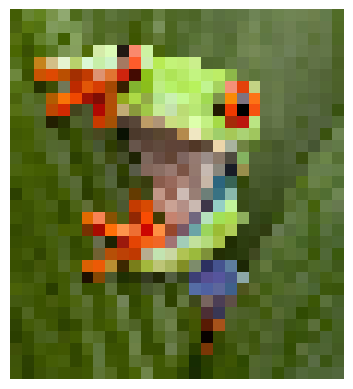

In [2]:
url_response = urllib.request.urlopen(IMG_URL)
img = cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(img, (0,0), fx=0.01, fy=0.01)
im_w, im_h = img.shape[0], img.shape[1]

plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
class NaiveEncoding(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear = nn.Linear(2, 64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x.float())

class LearnedEncoding(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Create learned embeddings for each position
        # We'll use embedding tables for width and height positions
        self.width_embedding = nn.Embedding(im_w, 32)
        self.height_embedding = nn.Embedding(im_h, 32)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x has shape [batch_size, 2] where x[:, 0] is width position and x[:, 1] is height position
        width_idx = x[:, 0].long()
        height_idx = x[:, 1].long()

        # Get embeddings
        width_emb = self.width_embedding(width_idx)  # [batch_size, 32]
        height_emb = self.height_embedding(height_idx)  # [batch_size, 32]

        # Concatenate to get 64-dimensional output
        return torch.cat([width_emb, height_emb], dim=1)  # [batch_size, 64]


class PositionalEncoding(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Positional encoding using sine and cosine functions
        # We'll create 32 frequencies for each coordinate (x and y)
        # Total: 32 * 2 * 2 = 128, but we'll use 16 frequencies to get 64 dims
        self.num_frequencies = 16

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x has shape [batch_size, 2]
        batch_size = x.shape[0]

        # Normalize coordinates to [0, 1]
        x_norm = x.float()
        x_norm[:, 0] = x_norm[:, 0] / (im_w - 1) if im_w > 1 else x_norm[:, 0]
        x_norm[:, 1] = x_norm[:, 1] / (im_h - 1) if im_h > 1 else x_norm[:, 1]

        # Create positional encoding
        encodings = []

        for i in range(self.num_frequencies):
            freq = 2 ** i
            # For x coordinate
            encodings.append(torch.sin(freq * math.pi * x_norm[:, 0]))
            encodings.append(torch.cos(freq * math.pi * x_norm[:, 0]))
            # For y coordinate
            encodings.append(torch.sin(freq * math.pi * x_norm[:, 1]))
            encodings.append(torch.cos(freq * math.pi * x_norm[:, 1]))

        # Stack all encodings: 16 frequencies * 4 (sin/cos for x and y) = 64
        return torch.stack(encodings, dim=1)  # [batch_size, 64]


# Define the network
class RGBNet(nn.Module):
    def __init__(self, encoding_type: Literal["naive", "learned", "positional"]) -> None:
        super().__init__()
        if encoding_type == "naive":
            self.encoding = NaiveEncoding()
        elif encoding_type == "learned":
            self.encoding = LearnedEncoding()
        elif encoding_type == "positional":
            self.encoding = PositionalEncoding()
        else:
            raise ValueError("Wrong encoding type!")
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoding(x)
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
def train(used_embedding: Literal["naive", "learned", "positional"]) -> torch.nn.Module:
    # Instantiate the model and set it to the GPU (if available)
    model = RGBNet(encoding_type=used_embedding)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define the loss function and optimizer
    criterion = nn.MSELoss(reduction="mean")
    optimizer = optim.AdamW(model.parameters(), lr=0.01)

    # Define the number of epochs and batch size
    num_epochs = 300
    batch_size = 32

    X, y = torch.cartesian_prod(torch.tensor(range(im_w)), torch.tensor(range(im_h))).to(device), torch.flatten(torch.tensor(img, dtype=torch.float32), start_dim=0, end_dim=1).to(device)

    model = model.train()

    # Train the model
    for epoch in range(num_epochs):
        total_loss = 0
        perm = torch.randperm(X.size(0))
        X, y = X[perm,:], y[perm, :]
        for i in range(0, X.shape[0], batch_size):
            # Get the current batch
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/X.size(0)}')
    return model

In [9]:
def visualize_model_output(model: RGBNet) -> None:
    # Set model to evaluation mode
    model.eval()

    device = next(model.parameters()).device

    # Create all pixel coordinates
    X = torch.cartesian_prod(torch.tensor(range(im_w)), torch.tensor(range(im_h))).to(device)

    # Generate predictions
    with torch.no_grad():
        predictions = model(X)

    # Reshape predictions to image shape
    predicted_img = predictions.cpu().numpy().reshape(im_w, im_h, 3)

    # Clip values to valid range [0, 255]
    predicted_img = np.clip(predicted_img, 0, 255).astype(np.uint8)

    # Display the predicted image
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_img)
    plt.title('Predicted Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    ...

Epoch [1/300], Loss: 142.93323639900453
Epoch [2/300], Loss: 99.95828359577513
Epoch [3/300], Loss: 81.27151784589213
Epoch [4/300], Loss: 69.42812069659958
Epoch [5/300], Loss: 74.13712377592167
Epoch [6/300], Loss: 66.45999342395413
Epoch [7/300], Loss: 63.0395267328359
Epoch [8/300], Loss: 57.24047429660498
Epoch [9/300], Loss: 64.46784990723782
Epoch [10/300], Loss: 53.876707015498994
Epoch [11/300], Loss: 54.66738954886863
Epoch [12/300], Loss: 50.25321021717265
Epoch [13/300], Loss: 55.830654443134364
Epoch [14/300], Loss: 55.249150922221524
Epoch [15/300], Loss: 54.50187693653019
Epoch [16/300], Loss: 50.94005865984798
Epoch [17/300], Loss: 51.131597140967024
Epoch [18/300], Loss: 54.27716359784526
Epoch [19/300], Loss: 55.511947069299936
Epoch [20/300], Loss: 55.70740139868952
Epoch [21/300], Loss: 51.00567127702423
Epoch [22/300], Loss: 46.59859248570034
Epoch [23/300], Loss: 45.39092071814471
Epoch [24/300], Loss: 45.01309436147663
Epoch [25/300], Loss: 51.9143323063301
Epoch

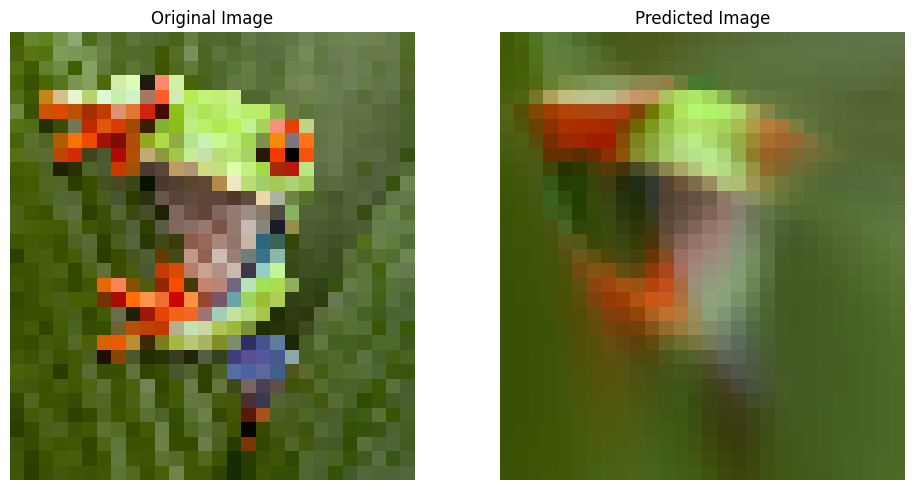

In [10]:
# IMPORTANT:
# training code works only for
# used_embedding = "naive"
# training and visualization code should work in both
# used_embedding = "learned"
# used_embedding = "positonal"
used_embedding = "naive"

torch.manual_seed(0)

model = train(used_embedding=used_embedding)
visualize_model_output(model)